In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Conv2D, Conv3D
from tensorflow.keras.layers import MaxPooling2D, MaxPooling3D
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras import optimizers
from tensorflow.keras import regularizers
from sklearn.metrics import f1_score
#from keras import backend as K
from keras.callbacks import EarlyStopping
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from PIL import Image 
import seaborn as sns
import os
import re
import glob
import cv2
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
from sklearn import preprocessing
import tqdm
from numpy import loadtxt
from sklearn.utils import class_weight

Using TensorFlow backend.


In [2]:
def atoi(text):
   return int(text) if text.isdigit() else text
def natural_keys(text):
   return [atoi(c) for c in re.split('(\d+)', text)]

In [3]:
def draw_confusion_matrix(true,preds):
    conf_matx = confusion_matrix(true, preds)
    sns.heatmap(conf_matx, annot=True,annot_kws={"size": 12},fmt='g', cbar=False, cmap=plt.cm.Blues) #'viridis'
    #plt.savefig('/home/jovyan/img1.png')
    plt.show()
    
    return conf_matx

In [4]:
def plot_history(model_history, model_name):
    fig = plt.figure(figsize=(15,5), facecolor='w')
    ax = fig.add_subplot(121)
    ax.plot(model_history.history['loss'])
    ax.plot(model_history.history['val_loss'])
    ax.set(title=model_name + ': Model loss', ylabel='Loss', xlabel='Epoch')
    ax.legend(['Train', 'Val'], loc='upper left')
    ax = fig.add_subplot(122)
    ax.plot(model_history.history['accuracy'])
    ax.plot(model_history.history['val_accuracy'])
    ax.set(title=model_name + ': Model Accuracy; test='+ str(np.round(model_history.history['val_accuracy'][-1], 3)),
           ylabel='Accuracy', xlabel='Epoch')
    ax.legend(['Train', 'Val'], loc='upper left')
    #plt.savefig('/home/jovyan/img2.png')
    plt.show()
   
    
    return fig

In [5]:
def loadImages():

    image_list = []
    

    for filename in sorted(glob.glob('/home/jovyan/DATA_MASTER_PROJECT/IMAGES_MASTER_PROJECT/Cropped_Image/Cropped_T_10_5_classes_conc_170/*.tiff'), key=natural_keys): 
        im=cv2.imread(filename)
        imarray = np.array(im)
        imarray = imarray.astype('float32')
        image_list.append(imarray)

    x_orig = np.reshape(image_list, (len(image_list), 90, 90, 3))
    
    path = '/home/jovyan/DATA_MASTER_PROJECT/leb_T10_P276_conc_170.csv'     
    labels = pd.read_csv(path, usecols=["Type", "Category"],
                       sep="," )
    y_orig = np.array(labels['Category'])

    return x_orig, y_orig

In [6]:
def normalization(data, norm_mean):#, norm_sigma):
    
    x_scaled = (data - norm_mean)# / norm_sigma
    data = x_scaled
    
    return data

In [7]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=2, patience=5)

In [8]:
def resize():
    rescaled = []

    for i in x_orig_1:

        scale_percent = 140 # percent of original size
        width = int(i.shape[1] / (scale_percent / 100))
        height = int(i.shape[0] / (scale_percent / 100))
        dim = (width, height)
        resized = cv2.resize(i, dim, interpolation = cv2.INTER_LANCZOS4)
        rescaled.append(resized)

    x_orig = np.reshape( rescaled, (len( rescaled), resized.shape[1], resized.shape[1], 3))

    return x_orig

In [9]:
x_orig_1, y_orig_1 = tqdm.tqdm(loadImages())
x_orig_1.shape, y_orig_1.shape

100%|██████████| 2/2 [00:00<00:00, 7981.55it/s]


((29407, 90, 90, 3), (29407,))

In [10]:
x_orig_1 = resize()
x_orig_1.shape

(29407, 64, 64, 3)

In [11]:
x_train, x_test, y_train, y_test = train_test_split(x_orig_1, y_orig_1, test_size=0.2, random_state=999 )
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((23525, 64, 64, 3), (5882, 64, 64, 3), (23525,), (5882,))

In [12]:
x_train_1, x_val, y_train_1, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=999 )
x_train_1.shape, x_val.shape, y_train_1.shape, y_val.shape

((18820, 64, 64, 3), (4705, 64, 64, 3), (18820,), (4705,))

In [13]:
pretrained_model = VGG16(weights='imagenet',include_top=False, input_shape=(64, 64, 3))

base_model = Model(inputs=pretrained_model.input, outputs=pretrained_model.get_layer('block3_pool').output)

In [14]:
unique, counts = np.unique(y_train_1, return_counts=True)
dict(zip(unique, counts))

{0: 1719, 1: 3113, 2: 3434, 3: 5304, 4: 5250}

In [15]:
unique, counts = np.unique(y_val, return_counts=True)
dict(zip(unique, counts))

{0: 434, 1: 789, 2: 840, 3: 1339, 4: 1303}

In [16]:
weights = class_weight.compute_class_weight('balanced', np.unique(y_train_1),y_train_1)
print('weights = ' + str(weights))

weights = [2.18964514 1.20912303 1.09609785 0.70965309 0.71695238]


In [17]:
y_train_1 = keras.utils.to_categorical(y_train_1)
y_test_1 = keras.utils.to_categorical(y_test)
y_val = keras.utils.to_categorical(y_val)

y_train_1.shape, y_test_1.shape, y_val.shape

((18820, 5), (5882, 5), (4705, 5))

In [36]:
print('Shape:{0}\nMean:{1}\nSigma:{2}'.format(x_train_1.shape,np.mean(x_train_1),np.std(x_train_1)))

Shape:(18820, 64, 64, 3)
Mean:-3.5812059650197625e-05
Sigma:13.97715950012207


In [19]:
norm_mean = np.mean(x_train_1)
norm_sigma = np.std(x_train_1)

x_train_1 = normalization(x_train_1, norm_mean)#, norm_sigma)

x_val = normalization(x_val, norm_mean)#, norm_sigma)

x_test = normalization(x_test, norm_mean)#, norm_sigma)


In [20]:
batch_size = 32

In [21]:
datagen = ImageDataGenerator()

datagen.fit(x_train_1)

train_gen = datagen.flow(x_train_1, y_train_1, batch_size=batch_size)

In [22]:
dat_val = ImageDataGenerator()

dat_val.fit(x_val)

val_gen = dat_val.flow(x_val, y_val, batch_size=batch_size)

In [23]:
m4 = Sequential()
m4.add(base_model)


m4.add(BatchNormalization())
m4.add(GlobalAveragePooling2D())
m4.add(Dense(64, activation='relu'))
m4.add(Dense(5, activation = 'softmax'))

m4.summary()




Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model (Model)                (None, 8, 8, 256)         1735488   
_________________________________________________________________
batch_normalization (BatchNo (None, 8, 8, 256)         1024      
_________________________________________________________________
global_average_pooling2d (Gl (None, 256)               0         
_________________________________________________________________
dense (Dense)                (None, 64)                16448     
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 325       
Total params: 1,753,285
Trainable params: 1,752,773
Non-trainable params: 512
_________________________________________________________________


In [24]:
base_model.trainable = False

opt = keras.optimizers.Adam(lr=1e-3)

m4.compile(loss= keras.losses.categorical_crossentropy, optimizer=opt, metrics = ['accuracy'])


In [25]:

epochs = 100

m4_h = m4.fit(train_gen,
                steps_per_epoch=(len(x_train_1)/batch_size),
                callbacks = [es],
                epochs=epochs,
                validation_data = val_gen, 
                validation_steps = (len(x_val)/batch_size),
                class_weight = weights)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 588.125 steps, validate for 147.03125 steps
Epoch 1/100
589/588 [==============================] - 9s 16ms/step - loss: 1.1116 - accuracy: 0.5541 - val_loss: 0.9803 - val_accuracy: 0.6168
Epoch 2/100
589/588 [==============================] - 6s 11ms/step - loss: 0.9169 - accuracy: 0.6461 - val_loss: 0.8872 - val_accuracy: 0.6516
Epoch 3/100
589/588 [==============================] - 6s 11ms/step - loss: 0.8295 - accuracy: 0.6833 - val_loss: 0.8241 - val_accuracy: 0.6806
Epoch 4/100
589/588 [==============================] - 6s 11ms/step - loss: 0.7658 - accuracy: 0.7072 - val_loss: 0.7814 - val_accuracy: 0.7092
Epoch 5/100
589/588 [==============================] - 6s 11ms/step - loss: 0.7220 - accuracy: 0.7282 - val_loss: 0.7535 - val_accuracy: 0.7197
Epoch 6/100
589/588 [==============================] - 6s 11ms/step - loss: 0.6823 - accuracy: 0.7457 - val_loss: 0.7232 - val_accuracy: 0.7318
Epoch 7/100
589/588 [===========

In [26]:
base_model.trainable = True

opt = keras.optimizers.Adam(lr=1e-5)

m4.compile(loss= keras.losses.categorical_crossentropy, optimizer=opt, metrics = ['accuracy'])

In [27]:

epochs = 100

m4_h = m4.fit(train_gen,
                steps_per_epoch=(len(x_train_1)/batch_size),
                callbacks = [es],
                epochs=epochs,
                validation_data = val_gen, 
                validation_steps = (len(x_val)/batch_size),
                class_weight = weights)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 588.125 steps, validate for 147.03125 steps
Epoch 1/100
589/588 [==============================] - 14s 23ms/step - loss: 0.3708 - accuracy: 0.8689 - val_loss: 0.8700 - val_accuracy: 0.7154
Epoch 2/100
589/588 [==============================] - 12s 21ms/step - loss: 0.3240 - accuracy: 0.8894 - val_loss: 0.6490 - val_accuracy: 0.7851
Epoch 3/100
589/588 [==============================] - 12s 21ms/step - loss: 0.2906 - accuracy: 0.9055 - val_loss: 0.6147 - val_accuracy: 0.7832
Epoch 4/100
589/588 [==============================] - 12s 21ms/step - loss: 0.2640 - accuracy: 0.9177 - val_loss: 0.7517 - val_accuracy: 0.7501
Epoch 5/100
589/588 [==============================] - 12s 21ms/step - loss: 0.2408 - accuracy: 0.9287 - val_loss: 0.6007 - val_accuracy: 0.7981
Epoch 6/100
589/588 [==============================] - 12s 21ms/step - loss: 0.2201 - accuracy: 0.9398 - val_loss: 0.6549 - val_accuracy: 0.7843
Epoch 7/100
589/588 [=====

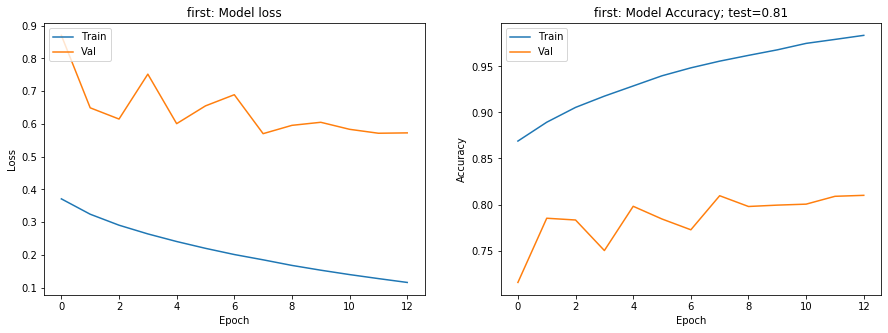

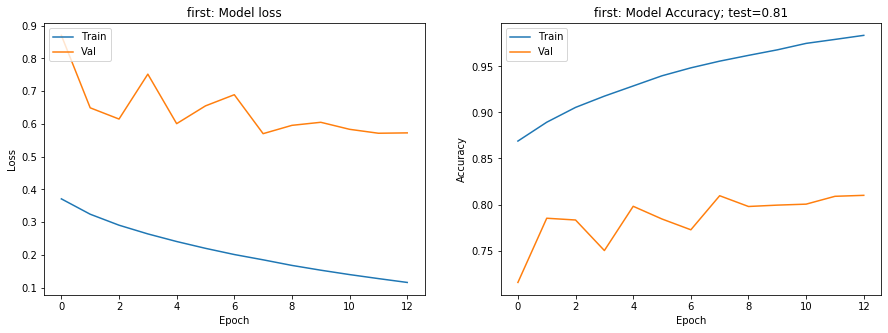

In [28]:
plot_history(m4_h, 'first')


In [29]:
scores = m4.evaluate(x_test, y_test_1)
print("\n%s: %.2f%%" % (m4.metrics_names[1], scores[1]*100))

5882/5882 [==============================] - 2s 276us/sample - loss: 0.5501 - accuracy: 0.8086

accuracy: 80.86%


In [30]:
test_preds = m4.predict(x_test)

In [31]:
preds_df = pd.DataFrame(test_preds)
predicted_labels = preds_df.idxmax(axis=1)

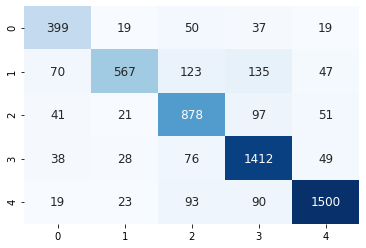

array([[ 399,   19,   50,   37,   19],
       [  70,  567,  123,  135,   47],
       [  41,   21,  878,   97,   51],
       [  38,   28,   76, 1412,   49],
       [  19,   23,   93,   90, 1500]])

In [32]:
draw_confusion_matrix(y_test, predicted_labels)

In [33]:
print(classification_report(y_test, predicted_labels))

              precision    recall  f1-score   support

           0       0.70      0.76      0.73       524
           1       0.86      0.60      0.71       942
           2       0.72      0.81      0.76      1088
           3       0.80      0.88      0.84      1603
           4       0.90      0.87      0.88      1725

    accuracy                           0.81      5882
   macro avg       0.80      0.78      0.78      5882
weighted avg       0.82      0.81      0.81      5882



In [35]:
p = '/home/jovyan/Saved_Models/'
m4.save(p + "CNN_T10_P010726_model_5.h5")